## Notes

1. the normalization of any of the probability does not matter as long as we are taking a ratio of likelihoods?
2. integration for hypothesis 2 is just product of "one star" case for i and j?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
style.use('notebook.mplstyle')

In [3]:
from scipy import integrate
import emcee, corner

In [4]:
%%time
from astropy.table import Table
t = Table.read('/Users/semyeong/data/gaia/tgas_source/stacked_tgas.fits')

CPU times: user 25 s, sys: 2.27 s, total: 27.3 s
Wall time: 32.4 s


In [5]:
def construct_cov(gaia_data):
    """
    If the real data look like the simulated data, Gaia will provide 
    correlation coefficients and standard deviations for 
    (ra,dec,parallax,pm_ra,pm_dec), but we probably want to turn that
    into a covariance matrix.
    """
    # p pmra pmdec vr
#     names = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
    names = ['parallax', 'pmra', 'pmdec', 'rv']
    
    n = len(gaia_data['ra_error'])
    C = np.zeros((n,len(names),len(names)))
    
    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
#         try:
        C[:,i,i] = gaia_data[full_name]**2
#         except KeyError:
#             C[:,i,i] = 0.
    
    for i,name1 in enumerate(names):
#         print i, name1
        for j,name2 in enumerate(names):
#             print i, name1, j, name2
            if j <= i: continue    
            full_name = "{}_{}_corr".format(name1, name2)
            C[...,i,j] = gaia_data[full_name]*np.sqrt(C[...,i,i]*C[...,j,j])
            C[...,j,i] = gaia_data[full_name]*np.sqrt(C[...,i,i]*C[...,j,j])
    
    return C

In [6]:
Ccol = construct_cov(t)
print Ccol.shape

KeyError: 'rv_error'

In [8]:
def prior_distance_uniform(d, rlim=1e3):
    """truncated uniform prior"""
    if d>0 and d<rlim:
        return 1./rlim
    return 0.

def prior_distance_constdens(d, rlim=1e3):
    """costant volume density prior on distance"""
    if d>0 and d<rlim:
        return 3./rlim**3 * d**2
    return 0.

def prior_distance_expcutoff(d, L=1e3):
    """constant density + exponential cut-off
    
    L : length scale"""
    if d>0:
        return 1./(2.*L**3) * d**2 * exp(-d/L)
    return 0.

def likelihood_gaussian(D, X, C):
    # gaussian likelihood at X given Data and Covariance matrix
    # X, D : 1-d array of size ndim
    # C : 2-d array of shape ndim, ndim
    ndim = X.size
    assert X.shape == D.shape, 'X and D must have the same shape'
    assert C.shape[0] == ndim, 'covariance matrix for %i must be %i, %i' % (ndim, ndim, ndim)
    R = D-X
    invC = inv(C)
    return float(sqrt(det(invC)/ (2.*pi)**ndim) * exp(-0.5 * R[newaxis].dot(invC).dot(R[newaxis].T)))

def prior_velocity_gaussian(v, sigv=30.):
    # isotropic velocity dispersion
    return 1./(sqrt(2.*pi)*sigv) * exp(-0.5*v**2/sigv**2)

In [69]:
def get_transform(ra, dec):
    return array([
            [cos(dec)*cos(ra),  cos(dec)*sin(ra), cos(dec)],
            [-cos(dec)*sin(ra),  cos(dec)*cos(ra), sin(dec)],
            [-sin(dec)*cos(ra), -sin(dec)*sin(ra), cos(dec)]])

def project_velocity(vx, vy, vz, ra, dec):
    ra = deg2rad(ra)
    dec = deg2rad(dec)
    A = get_transform(ra, dec)
    v = array([[vx, vy, vz]]).T
    v_radial, v_ra, v_dec = A.dot(v).flatten()
    return v_radial,v_ra, v_dec

# I can write inverse matrix explicitly if have to
def unproject_velocity(vr, vra, vdec, ra, dec):
    ra = deg2rad(ra)
    dec = deg2rad(dec)
    A = inv(get_transform(ra, dec))
    v = array([[vr, vra, vdec]]).T
    vx, vy, vz = A.dot(v).flatten()
    return vx, vy, vz

In [70]:
# ra, dec is given
def likelihood_one(ra, dec, p, pmra, pmdec, rv, d, vx, vy, vz, C):
    vr, vra, vdec = project_velocity(vx, vy, vz, ra, dec)
    D = array([p, pmra, pmdec, rv])
    X = array([1./d, vra/d/4.74, vdec/d/4.74, vr])
    return likelihood_gaussian(D, X, C)

In [54]:
print 4.74*5, 0, 0
a = project_velocity(4.74*5, 0, 0, 0, 0)
print a
print unproject_velocity(a[0], a[1], a[2], 0, 0)

23.7 0 0
(23.700000000000003, 0.0, 0.0)
(23.700000000000003, 0.0, 0.0)


In [109]:
# p pmra pmdec vr
# (i,4), (4,i) for i=1,2,3 component should be zero since RV is
# independent from everything else
C = array([
        [0.01, 0., 0., 0.],
        [0., 0.1, 0., 0.],
        [0., 0., 0.1, 0],
        [0., 0., 0., 1.]
    ])
print inv(C)
pmras = linspace(-5., 5., 100)
pmdecs = linspace(-5., 5., 100)
# rvs = linspace(3, 10, 50)
ll = []
for x in pmras:
    for y in pmdecs:
        ll.append(
            likelihood_one(180, 0, 1., x, y, 0,
                   1., 0, 4.74*2, 0., C)
            )

[[ 100.    0.    0.    0.]
 [   0.   10.    0.    0.]
 [   0.    0.   10.    0.]
 [   0.    0.    0.    1.]]


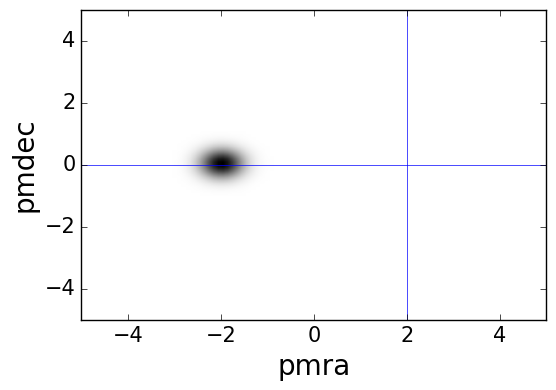

In [110]:
imshow(array(ll).reshape(100,100).T, origin='lower',
       extent=[-5,5, -5,5], aspect='auto', cmap='gray_r',)
axvline(2., lw=.5)
axhline(0., lw=.5)
xlabel('pmra')
ylabel('pmdec')

# One star

In [101]:
C = array([
        [0.01, 0., 0., 0.],
        [0., 0.1, 0., 0.],
        [0., 0., 0.1, 0],
        [0., 0., 0., 1.]
    ])

ra = 30.
dec = 30.
p1 = 1.
pmra = 2.5
pmdec = 0.
rv = 0.

# guess true d,vx,vy,vz
d = 1./p1
vx, vy, vz = unproject_velocity(rv, pmra/p1*4.74, pmdec/p1*4.74, ra, dec)
print d, vx, vy, vz

ndim = 4
def lnprob(x, *args):
    ll = likelihood_one(ra, dec, p1, pmra, pmdec, rv, x[0], x[1], x[2], x[3], C)
    pp = prior_distance_expcutoff(x[0])
    pv = prior_velocity_gaussian(x[1]) *prior_velocity_gaussian(x[2])*prior_velocity_gaussian(x[3])
    return log(ll*pp*pv)

1.0 -6.8416006899 11.85 1.86783312169e-16


In [102]:
nwalkers=10

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob,
    )

p0 = vstack([random.normal(1./p1, 1./p1*sqrt(C[0,0])/p1, nwalkers),
             random.normal(vx, 10., nwalkers),
             random.normal(vy, 10., nwalkers),
             random.normal(vz, 10., nwalkers)]).T

pos, prob, state = sampler.run_mcmc(p0, 5000)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/Users/semyeong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


[ 0.12220046  1.61254529  2.53992924  1.2545086 ]
1.51989605704e-21


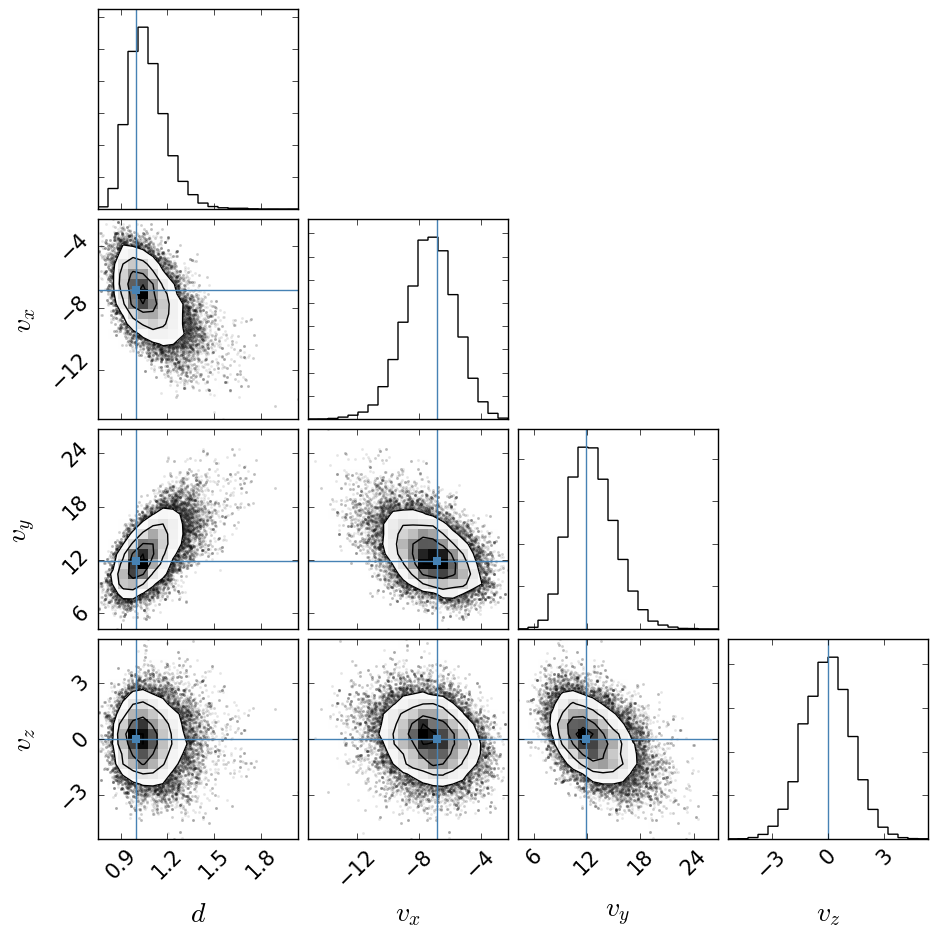

In [103]:
print std(samples, axis=0)
print mean([exp(lnprob(x)) for x in samples])
fig = corner.corner(
    samples,
    labels=['$d$', '$v_x$', r'$v_y$', r'$v_z$'],
    truths=[d, vx, vy, vz])

# Two stars with same velocity

In [104]:
def likelihood_binary(ra1, dec1, p1, pmra1, pmdec1, rv1,
                      ra2, dec2, p2, pmra2, pmdec2, rv2,
                      d1, d2, vx, vy, vz, C1, C2):
    l1 = likelihood_one(ra1, dec1, p1, pmra1, pmdec1, rv1,
                        d1, vx, vy, vz, C1)
    l2 = likelihood_one(ra2, dec2, p2, pmra2, pmdec2, rv2,
                        d2, vx, vy, vz, C2)
    pd1 = prior_distance_expcutoff(d1)
    pd2 = prior_distance_expcutoff(d2)
    pvxyz = prior_velocity_gaussian(vx)*\
            prior_velocity_gaussian(vy)*\
            prior_velocity_gaussian(vz)
    return l1*l2*pvxyz*pd1*pd2

In [116]:
C = array([
        [0.01, 0., 0., 0.],
        [0., 0.1, 0., 0.],
        [0., 0., 0.1, 0],
        [0., 0., 0., 1.]
    ])

ra1 = 30.
dec1 = 30.
p1 = 1.
pmra1 = 2.5
pmdec1 = 0.
rv1 = 5.
print 'star 1', rv1, pmra1, pmdec1

# guess true d,vx,vy,vz
d1 = 1./p1
vx1, vy1, vz1 = unproject_velocity(rv1, pmra1/p1*4.74, pmdec1/p1*4.74, ra1, dec1)
print 'd x y z', d1, vx1, vy1, vz1

# make second star slightly offset
ra2 = ra1 + 1.
dec2 = dec1 + 1.
p2 = 1.5
rv2, vra2, vdec2 = project_velocity(vx1, vy1, vz1, ra2, dec2)
pmra2 = vra2*p2/4.74
pmdec2 = vdec2*p2/4.74
print 'start 2', rv2, pmra2, pmdec2

star 1 5.0 2.5 0.0
d x y z 1.0 -3.06168536918 12.6235026919 2.11324865405
start 2 5.13482351003 3.70727737223 -0.0587031866266


In [117]:
ndim = 5
def lnprob_binary(x, *args):
    ll = likelihood_binary(ra1, dec1, p1, pmra1, pmdec1, rv1,
                           ra2, dec2, p2, pmra2, pmdec2, rv2,
                           x[0], x[1], x[2], x[3], x[4], C, C)
    pd1 = prior_distance_expcutoff(x[0])
    pd2 = prior_distance_expcutoff(x[1])
    pv = prior_velocity_gaussian(x[2]) *prior_velocity_gaussian(x[3])*prior_velocity_gaussian(x[4])
    return log(ll*pd1*pd2*pv)

In [118]:
nwalkers=10

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob_binary,
    )

p0 = vstack([random.normal(1./p1, 1./p1*sqrt(C[0,0])/p1, nwalkers),
             random.normal(1./p2, 1./p2*sqrt(C[0,0])/p2, nwalkers),
             random.normal(vx, 10., nwalkers),
             random.normal(vy, 10., nwalkers),
             random.normal(vz, 10., nwalkers)]).T

pos, prob, state = sampler.run_mcmc(p0, 5000)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/Users/semyeong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[ 0.10400992  0.04647993  0.94274948  1.29818022  0.69193838]
3.85466816319e-61


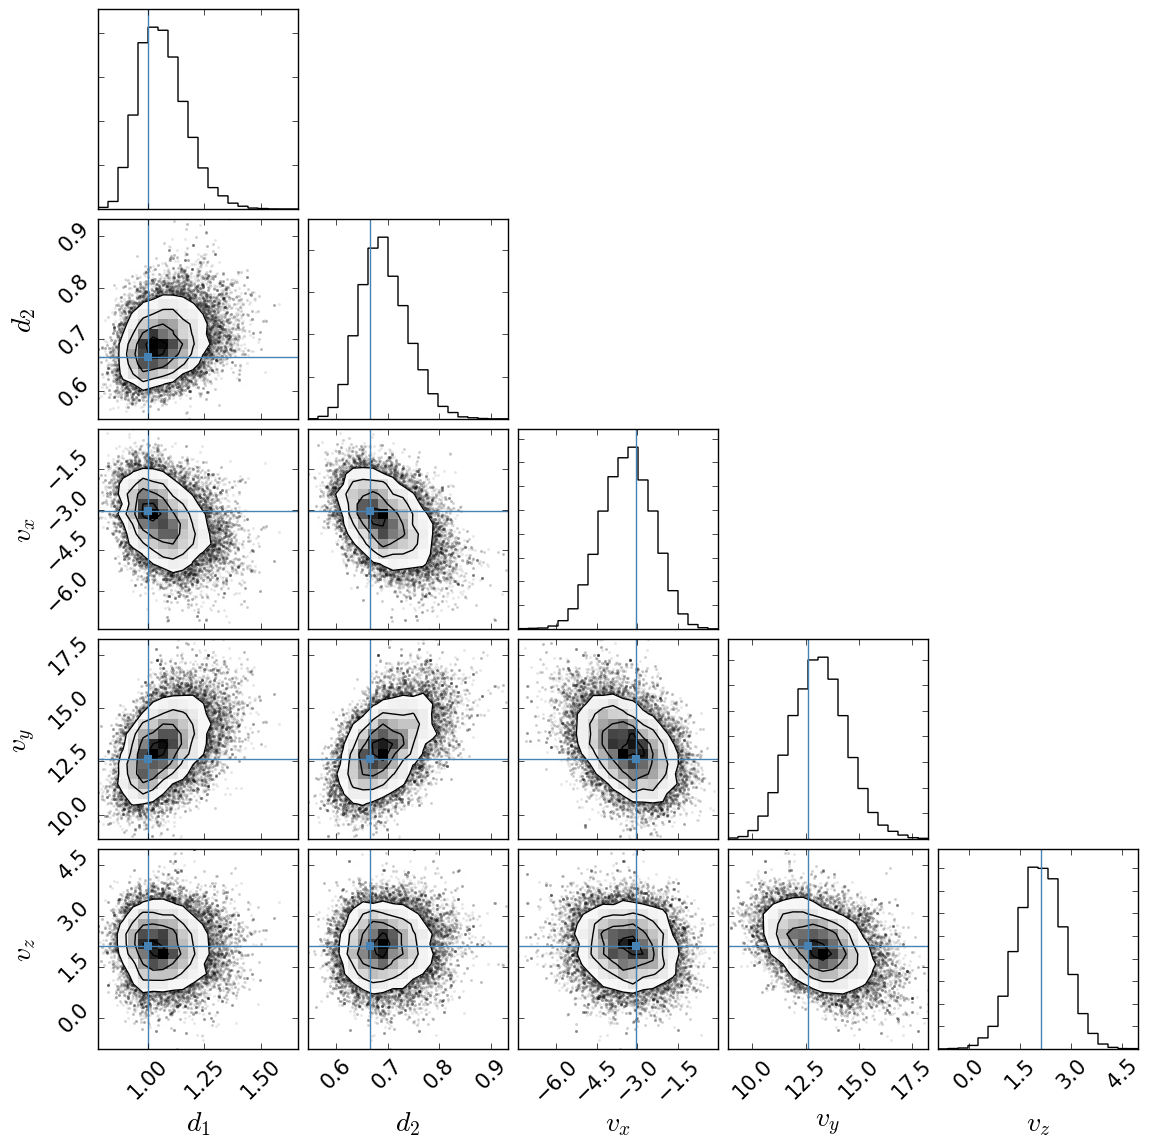

In [119]:
print std(samples, axis=0)
print mean([exp(lnprob_binary(x)) for x in samples])
fig = corner.corner(
    samples,
    labels=['$d_1$', '$d_2$', '$v_x$', r'$v_y$', r'$v_z$'],
    truths=[1./p1, 1./p2, vx1, vy1, vz1])

In [32]:
def likelihood(d1, d2, v_ra, v_dec, p1, p2, sigp1, sigp2, mu1, mu2, C1, C2):
    # mu: [pmra, pmdec]
    # v: [v_ra, v_dec]
    # d1,d2 : scalars
    v = array([v_ra, v_dec])
    Pmu1 = likelihood_gaussian(v/d1/4.74, mu1, C1)
    Pmu2 = likelihood_gaussian(v/d2/4.74, mu1, C2)
    Pd1 = post_distance(d1, p1, sigp1)
    Pd2 = post_distance(d2, p2, sigp2)
    Pv = prior_velocity_gaussian(v_ra, v_dec)
    return Pmu1*Pmu2*Pd1*Pd2

def likelihood_null(d1, d2, v1_ra, v1_dec, v2_ra, v2_dec, p1, p2, sigp1, sigp2, mu1, mu2, C1, C2):
    # mu: [pmra, pmdec]
    # v: [v_ra, v_dec]
    # d1,d2 : scalars
    v1 = array([v1_ra, v1_dec])
    Pmu1 = likelihood_gaussian(v1/d1/4.74, mu1, C1)
    v2 = array([v2_ra, v2_dec])
    Pmu2 = likelihood_gaussian(v2/d2/4.74, mu2, C2)
    Pd1 = post_distance(d1, p1, sigp1, prior=prior_distance_expcutoff)
    Pd2 = post_distance(d2, p2, sigp2, prior=prior_distance_expcutoff)
    Pv1 = prior_velocity_gaussian(v1_ra, v1_dec)
    Pv2 = prior_velocity_gaussian(v2_ra, v2_dec)
    return Pmu1*Pmu2*Pv1*Pv2*Pd1*Pd2